In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['test', 'state_labels.csv', 'color_labels.csv', 'train_sentiment', 'test_images', 'train_images', 'train_metadata', 'test_metadata', 'test_sentiment', 'train', 'breed_labels.csv']


## Project definition

* Goal: predict the adoptability of pets - specifically, how quickly is a pet adopted? predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted.
* Metric: quadratic weighted kappa, which measures the agreement between two ratings. it's calculated between the scores which are expected/known and the predicted scores.
    - -X: less than random agreement between raters
    - 0: random agreement between raters
    - 1: complete agreement between raters
* More at [Evaluation](https://www.kaggle.com/c/petfinder-adoption-prediction#evaluation)
* Data: text, tabular, image
    - train.csv, test.csv: tabular/text data
    - breed_sample.csv: Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat. 
    - color_labels.csv - Contains ColorName for each ColorID
    - state_labels.csv - Contains StateName for each StateID
    - images: For pets that have photos, they will be named in the format of PetID-ImageNumber.jpg. Image 1 is the profile (default) photo set for the pet. For privacy purposes, faces, phone numbers and emails have been masked.
    - image metadata: We have run the images through Google's Vision API, providing analysis on Face Annotation, Label Annotation, Text Annotation and Image Properties. You may optionally utilize this supplementary information for your image analysis. File name format is PetID-ImageNumber.json. Some properties will not exist in JSON file if not present, i.e. Face Annotation. Text Annotation has been simplified to just 1 entry of the entire text description (instead of the detailed JSON result broken down by individual characters and words). Phone numbers and emails are already anonymized in Text Annotation. Google Vision API reference: https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate
    - sentiment data: We have run each pet profile's description through Google's Natural Language API, providing analysis on sentiment and key entities. You may optionally utilize this supplementary information for your pet description analysis. There are some descriptions that the API could not analyze. As such, there are fewer sentiment files than there are rows in the dataset. File name format is PetID.json. Google Natural Language API reference: https://cloud.google.com/natural-language/docs/basics    
   

In [2]:
train = pd.read_csv('../input/train/train.csv')
test = pd.read_csv('../input/test/test.csv')

In [3]:
print("Shape of training set: ", train.shape)
print("Shape of test set: ", test.shape)

Shape of training set:  (14993, 24)
Shape of test set:  (3948, 23)


# Tabular data

### Data fields in train, test

* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below sec for more info. Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

In [4]:
train.sample(5)

Type     Name  Age      ...            PetID  PhotoAmt  AdoptionSpeed
11537     2   TamTam    3      ...        c19fa21be       3.0              4
14647     2     Eddy    6      ...        9f48a8fe6      12.0              4
7147      2     Noel    2      ...        b984a461b       7.0              2
8249      1  Hao Hao   12      ...        1f6dc1747      20.0              3
1901      2     Ozzy    3      ...        9676b5e36       1.0              3

[5 rows x 24 columns]

In [5]:
breed_labels = pd.read_csv('../input/breed_labels.csv')
color_labels = pd.read_csv('../input/color_labels.csv')
state_labels = pd.read_csv('../input/state_labels.csv')

In [6]:
breed_labels.sample(5)

BreedID  Type           BreedName
35        36     1  Bluetick Coonhound
141      142     1    Lakeland Terrier
53        54     1        Carolina Dog
217      218     1             Terrier
110      111     1          Great Dane

In [7]:
color_labels.sample(5)

ColorID ColorName
0        1     Black
4        5     Cream
1        2     Brown
2        3    Golden
3        4    Yellow

In [8]:
state_labels.sample(5)

StateID     StateName
3     41401  Kuala Lumpur
1     41325         Kedah
5     41324        Melaka
14    41361    Terengganu
7     41335        Pahang

# Images
(adapted from my [images notebook](https://www.kaggle.com/anebzt/images-preprocessing-model))

In [9]:
import cv2
from cv2 import imread, cvtColor, resize, threshold, calcHist, equalizeHist
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [10]:
def open_images(path):
    
    xall = []
    j = 0
    
    for imgname in os.listdir(path):
        print(f"Opening image #{str(j + 1)}, with filename {imgname}", end="\r")
        imgpath = os.path.join(path, imgname)
        img = imread(imgpath, cv2.IMREAD_COLOR)
        xall.append(img)
        j += 1
        
        # RAM breaks after 30k images
        if j >= 2000:
            break

    n = len(xall)
    print("\n{} images in set.".format(n))
    return xall

In [32]:
train_img = open_images("../input/train_images/")
test_img = open_images("../input/test_images/")

Opening image #2000, with filename 183c947eb-5.jpgg
2000 images in set.
Opening image #2000, with filename ea3303577-7.jpgg
2000 images in set.


## Image sizes

Let's check if all images have the same dimensions, and if not, let's decide to which dimension we should resize them.
Remember we only opened 2k images

In [22]:
minx, miny, mindim = train_img[0].shape
xs = []
ys = []
for el in train_img + test_img:
    x, y, dim = el.shape
    xs.append(x)
    ys.append(y)
    
    if x < minx:
        minx = x
    if y < miny:
        miny = y
    if dim < mindim:
        mindim = dim

minx, miny, mindim

(77, 85, 3)

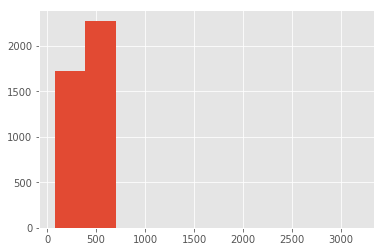

In [23]:
_xs = np.array(xs)
most_common_x = max(set(xs), key=xs.count)
plt.hist(_xs);
plt.show()

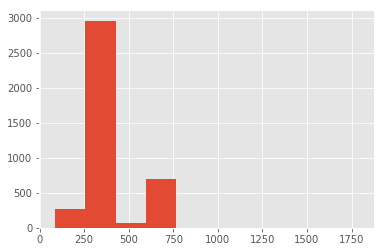

In [24]:
_ys = np.array(ys)
most_common_y = max(set(ys), key=ys.count)
plt.hist(_ys);
plt.show()

In [25]:
most_common_x, most_common_y

(480, 400)

In [33]:
def resize_imgs(lst):
    for i in range(0, len(lst)):
        print(f"Resizing image #{str(i + 1)}", end="\r")
        lst[i] = cv2.resize(lst[i], (most_common_x, most_common_y))
    print("\n")
    return lst

In [34]:
train_img_resized = resize_imgs(train_img)
test_img_resized = resize_imgs(test_img)

Resizing image #2000

Resizing image #2000



Most common Breeds of Small 2s:


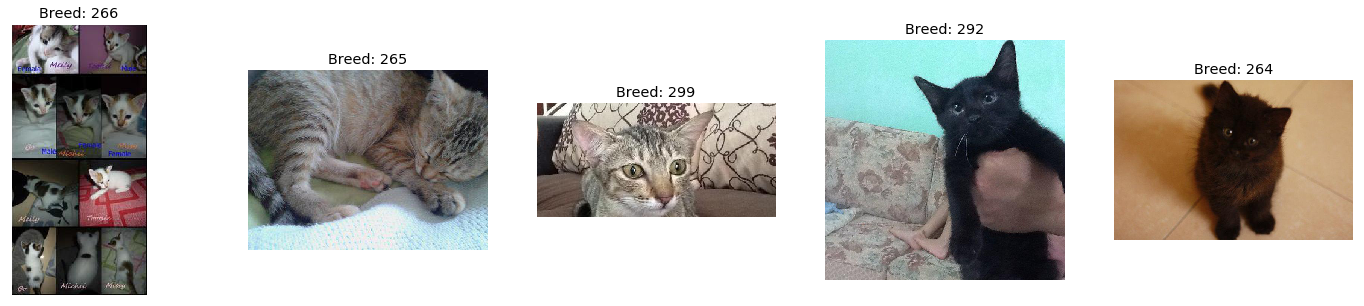

Most common Breeds of Medium 2s:


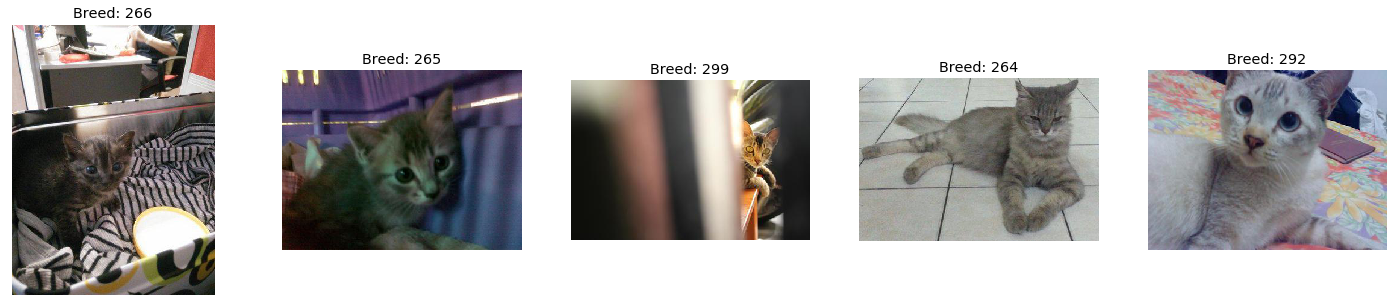

Most common Breeds of Large 2s:


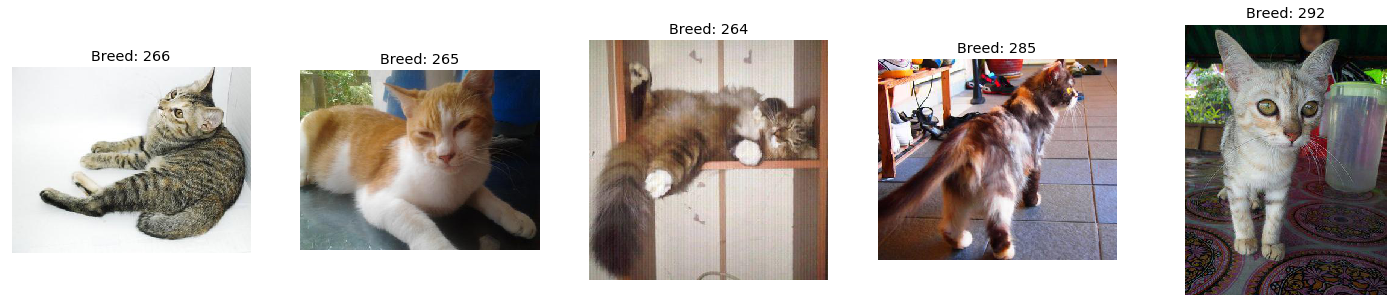

Most common Breeds of Extra Large 2s:


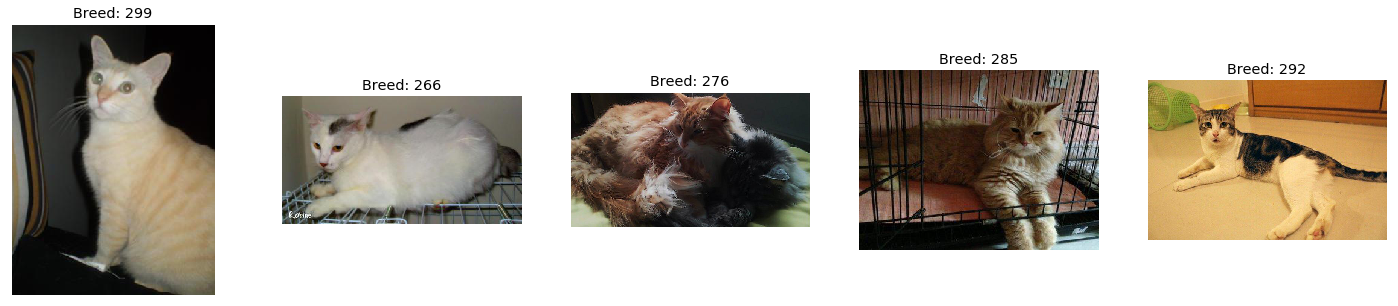

Most common Breeds of Small 1s:


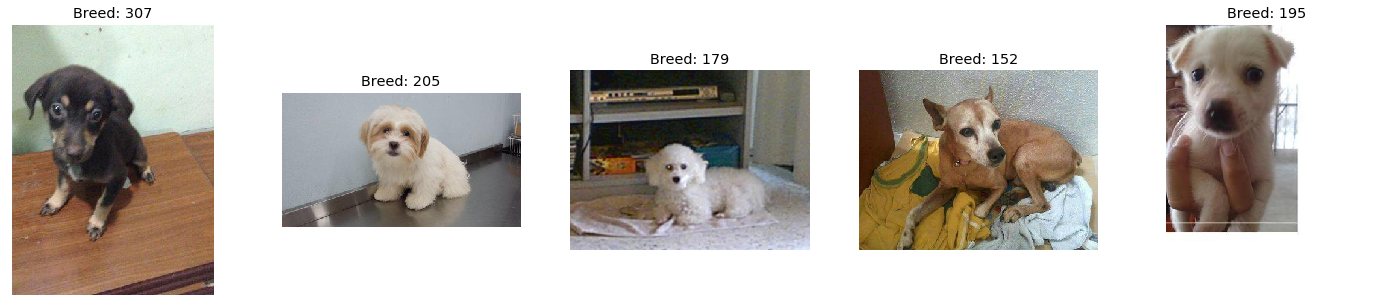

Most common Breeds of Medium 1s:


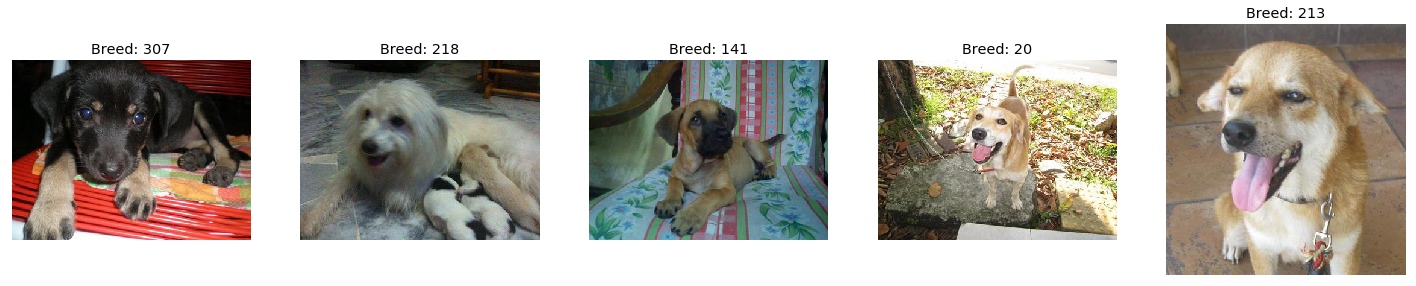

Most common Breeds of Large 1s:


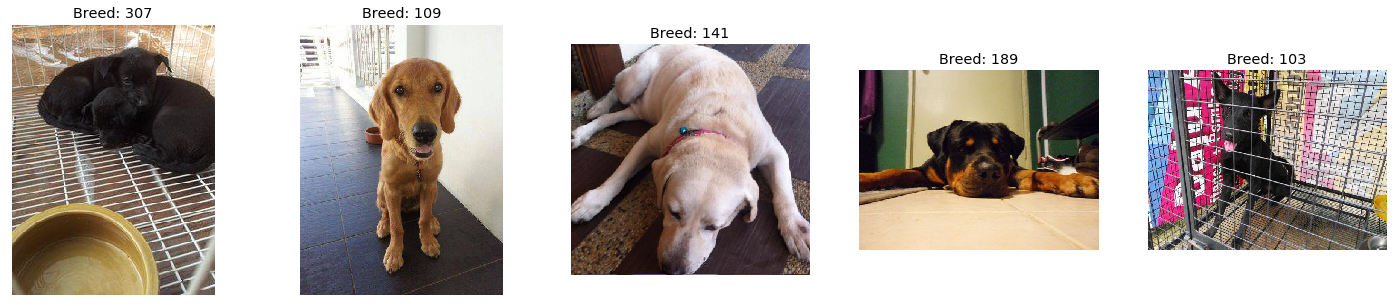

Most common Breeds of Extra Large 1s:


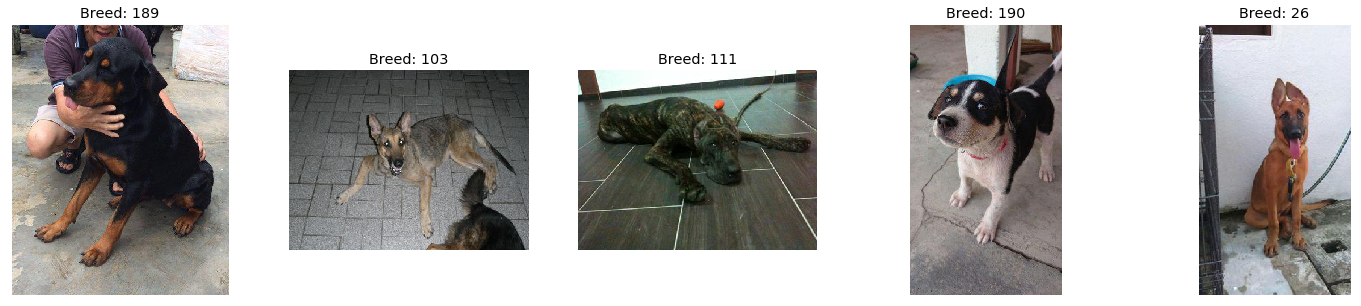

In [35]:
images = [i.split('-')[0] for i in os.listdir('../input/train_images/')]
size_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'} # MaturitySize
for t in train['Type'].unique(): # dog, cat
    for m in train['MaturitySize'].unique(): # 1,2,3,4
        df = train.loc[(train['Type'] == t) & (train['MaturitySize'] == m)] #df with all animals of same type and maturitySize
        top_breeds = list(df['Breed1'].value_counts().index)[:5] # most common breeds for this type and maturitySize
        print(f"Most common Breeds of {size_dict[m]} {t}s:")
        
        fig = plt.figure(figsize=(25, 5))
        
        for i, breed in enumerate(top_breeds): # i:index, breed:name
            # excluding pets without pictures
            b_df = df.loc[(df['Breed1'] == breed) & (df['PetID'].isin(images)), 'PetID']
            if len(b_df) > 1:
                pet_id = b_df.values[1]
            else:
                pet_id = b_df.values[0]
            ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])

            im = Image.open("../input/train_images/" + pet_id + '-1.jpg')
            plt.imshow(im)
            ax.set_title(f'Breed: {breed}')
        plt.show();

# Text

In [36]:
# For Word Count Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords 

In [57]:
descriptions = train.Description.tolist()

with open('descriptions.txt', 'w') as f:
    for item in descriptions:
        f.write("%s\n" % item)
        
df_nlp = train[['Description', 'AdoptionSpeed']]
df_nlp.sample(15)

# there are descriptions in other languages

Description  AdoptionSpeed
5523   Queenie is a sweet and friendly girl who uniqu...              3
10558  Sparkles is an adorable 3 month old girl who h...              4
1280   They were found roaming together looking for f...              1
3812   I'm moving to Sarawak in mid may, urgently nee...              2
3697   I found a puppy at road side...so pity...i can...              4
1546   Max was found running around at the Penchala L...              3
4827   Lovely and intelligent puppy looking for a for...              2
10898  Chester is a playful and smart dog. He is also...              2
4349   Been fostering them for 2 weeks, they're about...              1
12028  Hi Cat Lovers, Nigina (the one with orange col...              2
6326                                      Dog 4 Adoption              2
9391   I have adopted this lovely baby however curren...              1
4508   I recently got this cute lil' kitten to be a f...              1
6425   2 calico cat for adoption Female,cute and heal...              4
126    Rescued from the highway. gentle dog great wit...              3

In [50]:
print('There are ' + str(len(train[train.Description.isna()])) + ' elements without description')
train.dropna(subset=['Description'], inplace=True)

There are 12 elements without description


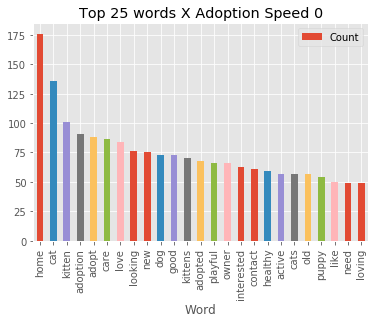

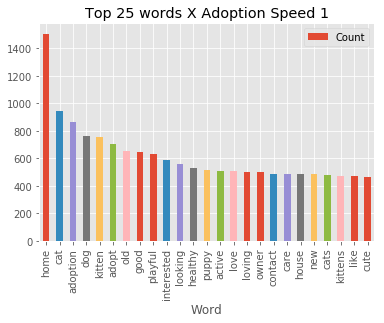

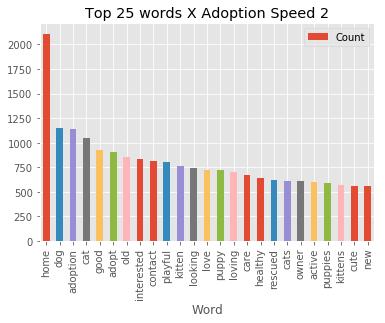

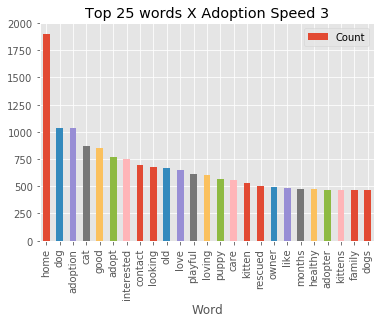

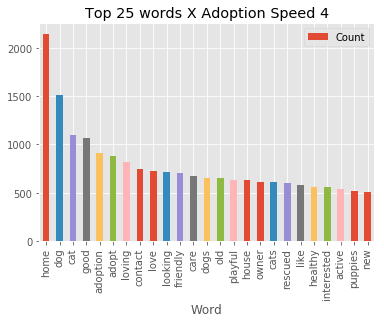

In [51]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{3,}', # vectorize 3-character words or more
            stop_words='english',
            ngram_range=(1, 2),
            max_features=30000
        ).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words_count_by_adoption_speed = []
for adoption_speed in range(5):
    descriptions_by_adoption_speed = train[train.AdoptionSpeed == adoption_speed].Description
    top_words = get_top_n_words(descriptions_by_adoption_speed, 25)
    words_count_by_adoption_speed.append(pd.DataFrame(top_words, columns = ['Word', 'Count'])) 
    words_count_by_adoption_speed[adoption_speed].plot.bar(x='Word',y='Count',title="Top 25 words X Adoption Speed " + str(adoption_speed))

## EDA kernels

* [EDA step by step, includes EDA from images](https://www.kaggle.com/artgor/exploration-of-data-step-by-step)
* [EDA and XGBoost baseline](https://www.kaggle.com/erikbruin/petfinder-my-detailed-eda-and-xgboost-baseline)
* [Something interesting about the table](https://www.kaggle.com/abhishek/maybe-something-interesting-here)
* [Very detailed EDA (in R)](https://www.kaggle.com/jaseziv83/eda-for-all-and-preprocessed-vars-except-images)
* [Quite general EDA: metadata as well](https://www.kaggle.com/alexandralorenzo/description-analysis-train-sentiment-and-metadata)

## Image kernels
* [Extract features from pre-trained NN](https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn)

## EDA metadata
* [Load data](https://www.kaggle.com/wakamezake/how-to-load-metadata-and-sentiment-data)
* [EDA 1](https://www.kaggle.com/harshc/image-metadata-data-analysis)

## Text
* [Section 4 (it's in R)](https://www.kaggle.com/jaseziv83/eda-for-all-and-preprocessed-vars-except-images))
* [Text mining (in R)](https://www.kaggle.com/francoisdubois/text-mining-on-description)
* [EDA texts](https://www.kaggle.com/rafaelleonhardt/petfinder-eda-focused-on-text-content)
* [Analyze sentiments and LGBM baseline](https://www.kaggle.com/nicapotato/text-and-structured-data-lgbm)
* [NLP EDA: tokenizing, visualizations (preprocessing stage)](https://www.kaggle.com/evaart/nlp-and-easy-ml)
